# Lab 6 Goals

The goals of this lab are:

* To implement $k$NN classification and regression. 
* To create a graph illustrating the effects of choosing $k$ on training and test set accuracy. 
* To implement neural networks using `keras` and `tensorflow`.

For this lab, it may be helpful to install and load the following modules:
 
* `numpy`
* `pandas`
* `plotnine`
* `random`
* `sklearn`
* `tensorflow`

`tensorflow` can be particularly tricky to install! If you are unsuccessful, I recommend trying the steps in this [tutorial for installing `tensorflow` with Anaconda](https://docs.anaconda.com/free/anaconda/applications/tensorflow/). You may have to download Miniconda, but you should be able to install the code in only a few steps. 

In [1]:
import keras
import numpy as np
import pandas as pd
import plotnine as p9
import random
import sklearn
import tensorflow

We will be using the birthweight dataset from Homeworks 3 and 4. Refresh yourself on the variables it includes by reading the [documentation](https://vincentarelbundock.github.io/Rdatasets/doc/MASS/birthwt.html).

In [3]:
birthwt = pd.read_csv("/Users/amynussbaum/Documents/U of C/Courses/119/Week 3/Homework/birthwt.csv")

0. As a preliminary step, go ahead and create indicator variables for the categorical variables. Then, "scramble" the rows so that when we are doing cross validation, we're not accidentally fitting models on unrepresentative data. If you want EXACTLY the same results as I have, use `random.seed(137)` first.

In [ ]:
random.seed(137)

birthwt = pd.get_dummies(birthwt, columns = ['race'])
birthwt = birthwt.sample(frac = 1)

# $k$NN

1. Recall that in Homeworks 3 and 4 we were interested in predicting `low` from `age`, `lwt`, `smoke`, `ptl`, `ht`, `ui`, `ftv`, and `race` (but not `bwt`, since that will predict `low` perfectly). First, read the documentation for [$k$NN Classification](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html) and [$k$NN Regression](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsRegressor.html). For predicting `low`, which is the most appropriate method to use? Split the data into `X` and `Y` dataframes to use later, and go ahead and scale the `X` data, storing it as `X_pp`, for use in our $k$NN model.

In [6]:
X = birthwt[['age', 'lwt', 'smoke', 'ptl', 'ht', 'ui', 'ftv', 'race_2', 'race_3']]
Y = birthwt['low']

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X)

X_pp = pd.DataFrame(scaler.transform(X), columns = [['age', 'lwt', 'smoke', 'ptl', 
                                                     'ht', 'ui', 'ftv', 'race_2', 'race_3']])

`low` \textcolor{blue}{is a binary response, so it is more appropriate to use classification rather than regression.}

2. *From Week 6 Course Notes, Monday, April 24:* Using the correct command from Step 1., write a line of code that specifies the number of neighbors in your classifier or regressor as $k = 5$. No need to fit anything yet, but name the model `knn5`. 

In [7]:
knn5 = sklearn.neighbors.KNeighborsClassifier(n_neighbors = 5)

3. Now, fit your classifier or regressor from Step 2. with `X_pp` and `Y` from Step 1. 


In [8]:
knn5_fit = knn5.fit(X_pp, Y)

4. Next, apply `.predict()` to get the predictions from the model in Step 3 (name them `knn5_preds` to use for later).


In [9]:
knn5_preds = knn5_fit.predict(X_pp)

5. *Week 4 Course Notes, Wednesday, April 12* Now, use `pd.crosstabs()` to calculate a confusion matrix for this model. What are the accuracy, sensitivity, and specificity?

In [10]:
cm = pd.crosstab(knn5_preds.tolist(), birthwt['low'])

(cm[0][0] + cm[1][1])/birthwt.shape[0] ## Accuracy
cm[1][1]/(cm[1][0] + cm[1][1]) ## Sensitivity
cm[0][0]/(cm[0][0] + cm[0][1]) ## Specificity

0.8923076923076924

6. Note that when you calculated the predictions, you were returned an array of 0's and 1's corresponding to a non-low birthweight and a low birthweight, respectively. This is not what we are used to--with the results of a logistic regression, for example, we see probabilities. To get probabilities out of a $k$NN model, use `.predict_proba()` and save the new predictions as `knn5_preds_proba`. What kind of results do you see?

In [11]:
knn5_preds_proba = knn5_fit.predict_proba(X_pp)
knn5_preds_proba.shape
#knn5_preds_proba

(189, 2)

\textcolor{blue}{Here, we are given an array--there are a few things going on inside.}

\textcolor{blue}{First, we note that the array has two columns. This is because there is one column representing the probability of a non-low birthweight (the first column, or the column indexed with zero) and one column representing the probability of a low birthweight (the second column, or the column indexed with a 1). As a self-check, look at a few of the rows in the array--they add up to one, as two complementary probabilities should. }

\textcolor{blue}{Second, note that there are only a few values in the array--specifically, 0, 0.2, 0.4, 0.6, 0.8, and 1. This is because we are looking at the five nearest neighbors of any given point! So  0, 0.2, 0.4, 0.6, 0.8, and 1 are the only possible values to see. }

7. *Week 5 Course Notes, Monday, April 17* Extract the second column of `knn5_preds_proba` to use as the predicted probabilities. Use that column, along with the column for the response variable, to calculate a ROC curve and value for AUC. Is this model a good model?

In [12]:
from sklearn.metrics import (confusion_matrix, accuracy_score)
from sklearn import metrics

fpr, tpr, thresholds = metrics.roc_curve(birthwt['low'], knn5_preds_proba[:,1],
                                           pos_label=1)
print(metrics.auc(fpr, tpr))

0.8176662320730117


\textcolor{blue}{This is pretty far above 0.5, and should be bigger than most of the values you have seen previously--I am pretty happy with it!}

# Choosing $k$

8. *From Week 6 Course Notes, Monday, April 24:* Let's move on to choosing the best value of $k$ for this data. Remember that we typically do so by using cross-validation, or at least using some model selection statistic on a test set. Let's proceed with taking a 70/30 split of our data. We have already randomized the rows, so we can actually just take the first 70\% of our data for training and keep the last 30\% for testing. Go ahead and do that now, but don't forget that you will need `X_in`, `X_out`, `Y_in`, and `Y_out`. 

In [13]:
X_in = X.iloc[0:(round(0.7*birthwt.shape[0])+1)]
X_out = X.iloc[(round(0.7*birthwt.shape[0])+1):]

Y_in = Y.iloc[0:(round(0.7*birthwt.shape[0])+1)]
Y_out = Y.iloc[(round(0.7*birthwt.shape[0])+1):]

9. Remember that we need to scale the data as well--if we used the scaled data from before, it would be scaled using statistics from all of the data, not just the training data. Go ahead and rescale `X_in` and `X_out` so that they both have column means all equal to 0 and column standard deviations all equal to 1. 

In [14]:
scaler = StandardScaler()
scaler.fit(X_in)

X_in_pp = pd.DataFrame(scaler.transform(X_in), columns = [['age', 'lwt', 'smoke', 
                                                           'ptl', 'ht', 'ui', 'ftv', 
                                                           'race_2', 'race_3']])
                                                          
scaler = StandardScaler()
scaler.fit(X_out)

X_out_pp = pd.DataFrame(scaler.transform(X_out), columns = [['age', 'lwt', 'smoke', 
                                                             'ptl', 'ht', 'ui', 'ftv', 
                                                             'race_2', 'race_3']])

10. *Week 5 Course Notes, Monday, April 17* Now, we need to write a loop again. The loop needs to search over a range of $k$ (I used 1 to 20), and in each iteration, fit a $k$NN model using the training set with the new value of $k$, predict the classes of the test set, and summarize the performance of the model using some appropriate value. Think back to your response to Step 1.--what are some appropriate model selection statistics that you can use for the type of response you chose?

\textcolor{blue}{We are still using a classifier for binary outputs, so things like accuracy, sensitivity, specificity, and AUC would all be appropriate.}

11. For simplicity, let's use accuracy. Fill in the loop below, storing the results from the test set in `metric`. You may want to use your code from Steps 3, 4, and 5. 

In [15]:
metric = []

for k in range(1, 21):
  tempknn = sklearn.neighbors.KNeighborsRegressor(n_neighbors = k)
  tempknn_preds = tempknn.fit(X_in_pp, Y_in).predict(X_out_pp) > 0.5 ## Why?
  tempknn_cm = pd.crosstab(tempknn_preds.tolist(), Y_out)
  metric.append((tempknn_cm[0][0] + tempknn_cm[1][1])/X_out.shape[0])

12. Which value of $k$ results in the highest test set accuracy?


In [16]:
metric.index(max(metric))


6

\textcolor{blue}{So, the maximum test set accuracy occurs at $k = 7$ (don't forget about the zero indexing!)}

13. Now, run the code below to create a plot showing the relationship between $k$ and test set accuracy. How would you describe this relationship? See if you can add a vertical line representing the best value of $k$. 

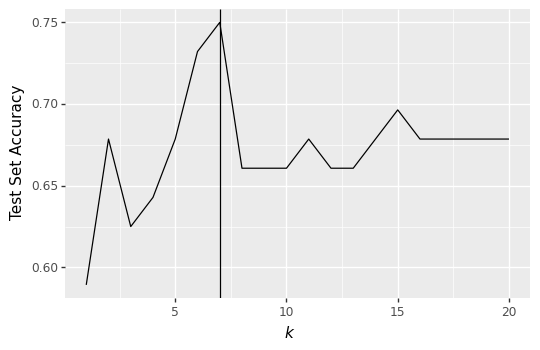

In [19]:
d_kNN = {'k': range(1, 21), 'Metric': metric}
kNN_plot = pd.DataFrame(data = d_kNN)  

print(p9.ggplot(kNN_plot, p9.aes(x = 'k', y = 'Metric')) +
       p9.geom_line() +
       p9.geom_vline(xintercept = 7) + 
       p9.scale_x_continuous(name = "$k$") + 
       p9.scale_y_continuous(name = "Test Set Accuracy") +
       p9.theme(legend_position = "none", figure_size = [6, 3.75]))

\textcolor{blue}{The accuracy is low at first, then grows bigger, then decreases again at a relatively stable rate.}

# Neural Networks

*From Week 6 Course Notes, Wednesday, April 26* As you know, neural networks are a popular type of deep learning algorithms. They are made up of networks of functions and can either perform classification or regression tasks. Recall that they have the following components:

* Input Layer
* Hidden Layer 
* Activation Functions
* Weights
* Output Layer

When coding a neural network, you need to take the time to properly set up each layer, but compiling the models is reasonably straightforward.

14. Let's begin by first creating a `Sequential` model--call it `model`.

In [20]:
model = keras.Sequential()

15. This code creates a structure to which we can add layers. Remember that each layer consists of a certain amount of units--the first layer takes in `input_dim` units, where `input_dim` is the number of features from the input layer. How many units should there be in the first layer if we are using the training and test sets you created from the `birthwt` data?

In [21]:
X_in_pp.shape

(133, 9)

\textcolor{blue}{There are nine features in the input layer.}

16. When we actually add the layer, we are going to use the `.add()` method with the `Dense()` function (both from `tensorflow`--it turns out that these methods are fairly good at detecting the number of input units, so you don't need to actually add `input_dim` to your function, but let's do it here anyway). You also have to add the number of units that come out of the layer with `units`, as well as an `activation` function. Explore the [documentation for `Dense()`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense)--what options do you see for `activation`?

\textcolor{blue}{This documentation shows that you can use two activation functions at the very least--} `'linear'` \textcolor{blue}{and} `'relu'` \textcolor{blue}{. Unfortunately, it doesn't show any other options, but from reading other tutorials I have also seen } `'sigmoid'` \textcolor{blue}{and} `'softmax'`\textcolor{blue}{. You can also read } [this tutorial on activations in `keras`](https://keras.io/api/layers/activations/) \textcolor{blue}{if you'd like even more options.}

17. Now, using `.add()` and `Dense()`, add a layer with 4 units that uses the ReLu activation function to your model. 


In [22]:
model.add(keras.layers.Dense(units = 4, input_dim = 9, activation = "relu"))

18. We could continue adding hidden layers (and I encourage you to try that eventually, perhaps on HW5), but let's review how to add the output layer. You use the same `.add()` and `Dense()` functions, but we have to pay careful attention to the number of units--we only need one unit since we just want one number (per observation). 

We also need to pay close attention to the activation function for the output layer. For a regression task, we need a special function, the identity function. This function takes in $x$ and returns $x$ itself. We didn't cover it in class this week, but I did mention it a while ago--this function is the `linear` function in `tensorflow`. 

Again, for a classification task, you need something different. However, you've already seen the possible options-- `'relu'` should work, as should `'softmax'` (which we did not cover in class). 

Add the output layer to your mode using `activation = 'softmax'`.

In [23]:
model.add(keras.layers.Dense(units = 1, input_dim = 4, activation = "relu"))

19. Now, it is time to compile your model with `.compile()`. Recall that training a network means finding the best set of weights to map inputs to outputs in our dataset. We must specify:

* The loss function to use to evaluate a set of weights,
* The optimizer (used to search through different weights)
* Optional metrics we would like to collect and report during training.

You know from other topics that loss functions are used to actually identify the parameters in the model. Here are some examples:

* Squared error: $\sum_{i = 1}^n (y_i - \hat{y}_i)^2$ 
* Absolute error: $\sum_{i = 1}^n |y_i - \hat{y}_i|$
* Binary cross-entropy (here, $y$ is binary and $\hat{y}$ is between 0 and 1): $\sum_{i = 1}^n -[y\text{log}(\hat{y}) - (1-y)\text{log}(1- \hat{y})]$
* Categorical cross entropy (multi-class classification; $C$ classes): $\sum_{i = 1}^n \sum_{c = 1}^C -y_{ic}\text{log}(\hat{y}_{ic})$

Remember that $\hat{y}$ is a function of the features and the corresponding parameters (e.g., in logistic regression, a function of $\beta_0 + \beta_1x_1 + ... + \beta_px_p$). You can see that there are different loss functions appropriate for different tasks (classification vs. regression)--since we are classifying a binary variable, we will use binary cross entropy as the loss argument. As optimizer, we use `"adam"`: an efficient optimization algorithm. Again, since we are classifying, we will collect and report the classification accuracy, defined via the `metrics` argument (see [the `keras` documentation](https://keras.io/api/metrics/) for more options). Run the line of code below. 


In [25]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

20. Finally, we can fit the model using `.fit()`. Some technical settings/terminology: training occurs over *epochs* and each epoch is split into *batches*.

* Epoch: One pass through all of the rows in the training dataset.
* Batch: samples considered by the model within an epoch before weights are updated.

One epoch is comprised of one or more batches, based on the chosen batch size and the model is fit for many epochs. Run the code chunk below--here, the training data is divided into batches of size 100 - weights are updated after each batch is analyzed.

Remember that we are using our training data to fit the model--run the code chunk below:

In [27]:
model.fit(X_in_pp, Y_in, epochs=10, batch_size=100)

Epoch 1/10
2/2 [==============================] - 0s 1ms/step - loss: 3.4349 - accuracy: 0.6391
Epoch 2/10
2/2 [==============================] - 0s 1ms/step - loss: 3.3513 - accuracy: 0.6391
Epoch 3/10
2/2 [==============================] - 0s 1ms/step - loss: 3.3399 - accuracy: 0.6391
Epoch 4/10
2/2 [==============================] - 0s 1ms/step - loss: 3.3291 - accuracy: 0.6391
Epoch 5/10
2/2 [==============================] - 0s 1ms/step - loss: 3.3218 - accuracy: 0.6391
Epoch 6/10
2/2 [==============================] - 0s 1ms/step - loss: 3.3171 - accuracy: 0.6391
Epoch 7/10
2/2 [==============================] - 0s 2ms/step - loss: 3.2288 - accuracy: 0.6391
Epoch 8/10
2/2 [==============================] - 0s 1ms/step - loss: 3.2188 - accuracy: 0.6391
Epoch 9/10
2/2 [==============================] - 0s 1ms/step - loss: 3.2127 - accuracy: 0.6391
Epoch 10/10
2/2 [==============================] - 0s 1ms/step - loss: 3.2066 - accuracy: 0.6391


21. The very last step is evaluation on a training set. We can do so using `.evaluate()`. How does your model perform on the test set?

In [28]:
model.evaluate(X_out_pp, Y_out, verbose = 0)


[2.8921127319335938, 0.6428571343421936]

22. When you are done working your way through the neural network steps above, try creating some new neural networks. Be sure to experiment with the number of layers, the units in each layer, the activation functions, the epochs and batches, and the performance metrics. Can you create a new network that outperforms $k$NN?
